In [1]:
'''
connect to the milvus vdb

connect to the sql db

populating vdb:

{ access the correct historical data area of sql db

for(each time point in db) {

read line items into vector embedding API

write vectors to vdb} }

generating forecast:

variables defining how to weight similarity of different aspects

{access the correct weather forecast area of sql db

for (forecast line by line) {

read forecast line

similarity search query to find options for best fit from historical data

return forecast line for timestamp

write forecast to sql db in column next to weather forecast} }

Synthesizing forecasts:

access the forecast area of the sql db

retrieve datapoints from each forecast line by line

perform data averaging for each line and store to next column in db

perform sinusoidal smoothing and store smoothed data to next column

data format: region/year/date/time/temp/precip/otherweather/power
'''

'\nconnect to the milvus vdb\n\nconnect to the sql db\n\npopulating vdb:\n\n{ access the correct historical data area of sql db\n\nfor(each time point in db) {\n\nread line items into vector embedding API\n\nwrite vectors to vdb} }\n\ngenerating forecast:\n\nvariables defining how to weight similarity of different aspects\n\n{access the correct weather forecast area of sql db\n\nfor (forecast line by line) {\n\nread forecast line\n\nsimilarity search query to find options for best fit from historical data\n\nreturn forecast line for timestamp\n\nwrite forecast to sql db in column next to weather forecast} }\n\nSynthesizing forecasts:\n\naccess the forecast area of the sql db\n\nretrieve datapoints from each forecast line by line\n\nperform data averaging for each line and store to next column in db\n\nperform sinusoidal smoothing and store smoothed data to next column\n\ndata format: region/year/date/time/temp/precip/otherweather/power\n'

In [1]:
# Populate data into Milvus vdb

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import pymilvus
import time
from pathlib import Path
from pymilvus import (
    connections,
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection,
)
from sqlalchemy import create_engine, MetaData
from sqlalchemy.engine import URL
import pypyodbc

connections.connect(
  alias="default",
  user='root',
  password='tecafs',
  host='localhost',
  port='19530'
)
connections.list_connections()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## SQL queries slot in here
'''
###
# declares the variables and defines them for the server connections, along with the table names that are going to be assigned
SERVER_NAME = 'tcp:tecafs.database.windows.net,1433'
DATABASE_NAME = 'TecafsSqlDatabase'
TABLE_NAME = 'clean_data'

###################################

# makes the connection to the database with the connection string; has the driver, server name, database name, id, and password
connection_string = f"""
    DRIVER={{ODBC Driver 18 for SQL Server}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Uid={'tecafs2023'};
    Pwd={'Capstone50'};
"""
###################################


connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
engine = create_engine(connection_url, module=pypyodbc)

# Define the SQL query

query = """
    SELECT * FROM clean_data 
    WHERE DATEPART(month, hour_end) = 1
    AND DATEPART(year, hour_end) = 2013;
"""

# Execute the query and load data into a DataFrame
jan_data = pd.read_sql(query, engine)

# Print the DataFrame
#print(jan_data)


query = """
    SELECT * FROM clean_data
    WHERE south_c >= 8000;
"""

# Execute the query and load data into a DataFrame
large_power = pd.read_sql(query, engine)

# Print the DataFrame
#print(large_power)

###
'''
# Read in the CSV file
data_folder = Path("/mnt/c/Users/wcans/milvus_compose/ERCOT_Hourly_Load_2022/")
csv_file_path = data_folder / "small_historical_data.csv" 
df = pd.read_csv(csv_file_path)

##

def get_embedding(prevec):
    text = [prevec] #remove brackets should fix extra bracket issue
    embedding = model.encode(text)
    return embedding

# Create the prevec conglomeration by combining values from other columns and embed it into 'vector' column 
df['vector'] = df.apply(lambda row: get_embedding(f"{row['year']}/{row['date']}/{row['time']}/{row['time']}/{row['time']}/{row['temp']}/{row['precip']}/{row['humidity']}"), axis=1)

# Fix formatting (remove extra brackets)
df['vector'] = df['vector'].apply(lambda row: row[0])
print(df)

# Prepare milvus collection to add data
collection_name = "small_historical_data_3"
collection = Collection(collection_name)

# Create an IVF_FLAT index for collection.
index_params = {
    'metric_type':'L2',
    'index_type':"IVF_FLAT",
    'params':{'nlist': 1536}
}
collection.create_index(field_name="vector", index_params=index_params)
collection.load()

# Insert data
collection.insert(df)
collection.load()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                                                vector location  year   date  \
0    [-0.0114821205, -0.016558707, -0.028107373, 0....    SCENT  2022  01-01   
1    [-0.021339186, -0.025851091, -0.030772733, 0.0...    SCENT  2022  01-01   
2    [-0.024244668, -0.031528812, -0.032450024, 0.0...    SCENT  2022  01-01   
3    [-0.007895104, 0.0015809466, -0.013399365, -0....    SCENT  2022  01-01   
4    [-0.023762126, -0.025042797, -0.028171899, 0.0...    SCENT  2022  01-01   
..                                                 ...      ...   ...    ...   
739  [-0.040389467, -0.026455313, -0.01462347, 0.00...    SCENT  2022  01-31   
740  [-0.033543415, -0.04421887, -0.03185819, -0.00...    SCENT  2022  01-31   
741  [-0.031826835, -0.037355635, -0.034037333, -0....    SCENT  2022  01-31   
742  [-0.03533846, -0.015965832, -0.020646924, 0.00...    SCENT  2022  01-31   
743  [-0.02511708, -0.036681447, -0.028635306, 0.00...    SCENT  2022  02-01   

      time  temp  precip  humidity    p

In [ ]:
def get_embedding(prevec):
    text = [prevec]
    embedding = model.encode(text)
    return embedding

# Create the 'prevec' column by combining values from other columns
df['vector'] = df.apply(lambda row: get_embedding(f"{row['year']}/{row['year']}/{row['date']}/{row['time']}/{row['temp']}/{row['temp']}/{row['temp']}/{row['precip']}/{row['humidity']}"), axis=1)
df['vector'] = df['vector'].apply(lambda row: row[0])


In [54]:
##print(df)

# Write the modified DataFrame back to a new CSV file
#output_csv_file_path = data_folder / 'small_historical_data_2.csv'  # Replace with the desired output path
#df.to_csv(output_csv_file_path, index=False)

                                                vector location  year   date  \
0    [[-0.019725367, 0.024870519, -0.019531233, 0.0...    SCENT  2022  01-01   
1    [[-0.03027626, 0.017317045, -0.026152529, 0.03...    SCENT  2022  01-01   
2    [[-0.031512834, 0.010733103, -0.026938722, 0.0...    SCENT  2022  01-01   
3    [[-0.027203996, 0.037004102, -0.0072827013, 0....    SCENT  2022  01-01   
4    [[-0.030876294, 0.016844494, -0.019014584, 0.0...    SCENT  2022  01-01   
..                                                 ...      ...   ...    ...   
739  [[-0.06061097, 0.004243961, -0.0093321325, 0.0...    SCENT  2022  01-31   
740  [[-0.047124248, -0.015535077, -0.026949378, 0....    SCENT  2022  01-31   
741  [[-0.056392066, -0.007901729, -0.02678549, 0.0...    SCENT  2022  01-31   
742  [[-0.05358566, 0.01122651, -0.01313172, 0.0223...    SCENT  2022  01-31   
743  [[-0.033886462, -0.016373537, -0.02344224, 0.0...    SCENT  2022  02-01   

      time  temp  precip  humidity    p

In [106]:
## Similarity Search

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
collection = Collection("small_historical_data_2")      # Get an existing collection.
collection.load()

def get_embedding(prevec):
    text = [prevec]
    embedding = model.encode(text)
    return embedding

def search(text, top_k = 10):

    # AUTOINDEX does not require any search params 
    search_params = {
        "metric_type": "L2"
    }

    results = collection.search(
        data = [text],
        anns_field='vector',
        param=search_params,
        limit = top_k,  # Limit to top_k results per search
        ##output_fields=['original_question', 'answer']  # Include the original question and answer in the result
        output_fields=['index', 'year', 'date', 'time', 'temp', 'precip', 'humidity', 'power']
    )
    avg_power = 0
    
    ret = []
    for hit in  results[0]:
        row = []
        row.extend([hit.id, hit.score, hit.entity.get('year'), hit.entity.get('date'), hit.entity.get('time'), hit.entity.get('temp'), hit.entity.get('precip'), hit.entity.get('humidity'), hit.entity.get('power')])
        ret.append(row)
        avg_power += hit.entity.get('power')
    print('average power: ', 0.97*avg_power/top_k)
    return ret

# search this vector
s_year= 2023
s_date= '01-15'
s_time= '06:00'
s_temp= 37
s_precip= 0.0
s_humidity= 100
correct_power= 5928.75
search_vector = get_embedding('/'.join(map(str, [s_year, s_date, s_time, s_temp, s_precip, s_humidity])))
search_vector = search_vector[0]

#print(search_vector)
# Print out the results with all schema
for result in search(search_vector):
    print(result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

average power:  6574.70559
[445759463158117334, 0.1001286655664444, 2022, '01-05', '06:00', 39, 0.0, 100, 6303.64]
[445759463158117367, 0.10755540430545807, 2022, '01-06', '15:00', 55, 0.0, 34, 6325.22]
[445759463158117375, 0.1331852674484253, 2022, '01-06', '23:00', 35, 0.0, 50, 7911.91]
[445759463158117290, 0.13322043418884277, 2022, '01-03', '10:00', 39, 0.0, 57, 9300.18]
[445759463158117919, 0.1333463340997696, 2022, '01-29', '15:00', 66, 0.0, 17, 5965.27]
[445759463158117677, 0.13479533791542053, 2022, '01-19', '13:00', 75, 0.0, 57, 6328.45]
[445759463158117962, 0.138890340924263, 2022, '01-31', '10:00', 53, 0.3, 100, 6918.24]
[445759463158117961, 0.13965514302253723, 2022, '01-31', '09:00', 53, 0.6, 100, 6837.38]
[445759463158117365, 0.14188870787620544, 2022, '01-06', '13:00', 56, 0.0, 39, 6479.77]
[445759463158117670, 0.14290118217468262, 2022, '01-19', '06:00', 63, 0.0, 90, 5410.41]


In [107]:
# search this vector
s_year= 2023
s_date= '01-20'
s_time= '12:00'
s_temp= 55
s_precip= 0.0
s_humidity= 47
correct_power= 7051.88
search_vector = get_embedding('/'.join(map(str, [s_year, s_date, s_time, s_temp, s_precip, s_humidity])))
search_vector = search_vector[0]

#print(search_vector)
# Print out the results with all schema
for result in search(search_vector):
    print(result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

average power:  6959.565700000001
[445759463158117538, 0.0739913061261177, 2022, '01-13', '18:00', 55, 0.0, 47, 6482.22]
[445759463158117702, 0.08115662634372711, 2022, '01-20', '14:00', 33, 0.0, 50, 8708.78]
[445759463158117868, 0.08671209216117859, 2022, '01-27', '12:00', 55, 0.0, 49, 6782.91]
[445759463158117708, 0.09098787605762482, 2022, '01-20', '20:00', 33, 0.0, 52, 9575.66]
[445759463158117780, 0.09223303198814392, 2022, '01-23', '20:00', 52, 0.0, 47, 7377.77]
[445759463158117564, 0.09237945824861526, 2022, '01-14', '20:00', 54, 0.0, 51, 6738.91]
[445759463158117879, 0.0927833765745163, 2022, '01-27', '23:00', 55, 0.0, 55, 6327.86]
[445759463158117691, 0.0944838896393776, 2022, '01-20', '03:00', 40, 0.0, 55, 6201.76]
[445759463158117847, 0.0946999341249466, 2022, '01-26', '15:00', 53, 0.0, 48, 6766.73]
[445759463158117540, 0.09562571346759796, 2022, '01-13', '20:00', 48, 0.0, 61, 6785.5]


In [108]:
# search this vector
s_year= 2023
s_date= '01-22'
s_time= '17:00'
s_temp= 60
s_precip= 0.0
s_humidity= 28
correct_power= 6130.20
search_vector = get_embedding('/'.join(map(str, [s_year, s_date, s_time, s_temp, s_precip, s_humidity])))
search_vector = search_vector[0]

#print(search_vector)
# Print out the results with all schema
for result in search(search_vector):
    print(result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

average power:  6258.9143300000005
[445759463158117629, 0.06581643223762512, 2022, '01-17', '13:00', 60, 0.0, 27, 6604.22]
[445759463158117945, 0.06962063908576965, 2022, '01-30', '17:00', 67, 0.0, 33, 5929.47]
[445759463158117896, 0.07243873178958893, 2022, '01-28', '16:00', 58, 0.0, 27, 6418.9]
[445759463158117922, 0.07791060209274292, 2022, '01-29', '18:00', 56, 0.0, 28, 6138.17]
[445759463158117586, 0.08256272971630096, 2022, '01-15', '18:00', 47, 0.0, 28, 7364.22]
[445759463158117944, 0.08378524333238602, 2022, '01-30', '16:00', 69, 0.0, 27, 5818.57]
[445759463158117902, 0.08425402641296387, 2022, '01-28', '22:00', 38, 0.0, 60, 7650.15]
[445759463158117895, 0.08529336005449295, 2022, '01-28', '15:00', 58, 0.0, 28, 6507.84]
[445759463158117941, 0.0855579525232315, 2022, '01-30', '13:00', 67, 0.0, 31, 6155.82]
[445759463158117942, 0.08801001310348511, 2022, '01-30', '14:00', 67, 0.0, 26, 5937.53]


In [109]:
# search this vector
s_year= 2023
s_date= '01-22'
s_time= '19:00'
s_temp= 46
s_precip= 0.0
s_humidity= 46
correct_power= 6870.86
search_vector = get_embedding('/'.join(map(str, [s_year, s_date, s_time, s_temp, s_precip, s_humidity])))
search_vector = search_vector[0]

#print(search_vector)
# Print out the results with all schema
for result in search(search_vector):
    print(result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

average power:  6930.13008
[445759463158117687, 0.07262447476387024, 2022, '01-19', '23:00', 46, 0.0, 54, 6056.13]
[445759463158117701, 0.07603835314512253, 2022, '01-20', '13:00', 34, 0.0, 46, 8769.86]
[445759463158117653, 0.08074453473091125, 2022, '01-18', '13:00', 71, 0.0, 47, 6295.53]
[445759463158117855, 0.08226664364337921, 2022, '01-26', '23:00', 46, 0.0, 68, 7036.0]
[445759463158117298, 0.08362801373004913, 2022, '01-03', '18:00', 46, 0.0, 34, 7207.57]
[445759463158117773, 0.0843721330165863, 2022, '01-23', '13:00', 54, 0.0, 33, 7057.81]
[445759463158117763, 0.08586151897907257, 2022, '01-23', '03:00', 44, 0.0, 58, 6574.65]
[445759463158117714, 0.08674794435501099, 2022, '01-21', '02:00', 31, 0.0, 46, 8545.9]
[445759463158117869, 0.08675279468297958, 2022, '01-27', '13:00', 57, 0.0, 49, 6532.73]
[445759463158117779, 0.08791933953762054, 2022, '01-23', '19:00', 53, 0.0, 43, 7368.46]


In [117]:
## Single Day Forecast - outdated, go to 403 demo document

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Read in the CSV file
data_folder = Path("/mnt/c/Users/wcans/milvus_compose/ERCOT_Hourly_Load_2022/")
csv_file_path = data_folder / "single_day_forecast1.csv"  # Replace with the path to your CSV file
forecast_df = pd.read_csv(csv_file_path)

def get_embedding(prevec):
    text = [prevec]
    embedding = model.encode(text)
    return embedding

forecast_df['vector'] = forecast_df.apply(lambda row: get_embedding(f"{row['year']}/{row['date']}/{row['time']}/{row['temp']}/{row['precip']}/{row['humidity']}"), axis=1)
forecast_df['vector'] = forecast_df['vector'].apply(lambda row: row[0])

collection = Collection("small_historical_data")      # Get an existing collection.
collection.load()

def search(text, top_k = 10):

    # AUTOINDEX does not require any search params 
    search_params = {
        "metric_type": "L2"
    }

    results = collection.search(
        data = [text],
        anns_field='vector',
        param=search_params,
        limit = top_k,  # Limit to top_k results per search
        ##output_fields=['original_question', 'answer']  # Include the original question and answer in the result
        output_fields=['index', 'year', 'date', 'time', 'temp', 'precip', 'humidity', 'power']
    )
    avg_power = 0
    
    #ret = []
    for hit in  results[0]:
        #row = []
        #row.extend([hit.id, hit.score, hit.entity.get('year'), hit.entity.get('date'), hit.entity.get('time'), hit.entity.get('temp'), hit.entity.get('precip'), hit.entity.get('humidity'), hit.entity.get('power')])
        #ret.append(row)
        avg_power += hit.entity.get('power')
    avg_power= 0.97*(avg_power/top_k)
    return avg_power
    
# search this vector
'''
s_year= 2023
s_date= '01-15'
s_time= '06:00'
s_temp= 37
s_precip= 0.0
s_humidity= 100
correct_power= 5928.75
'''
#search_vector = get_embedding('/'.join(map(str, [s_year, s_date, s_time, s_temp, s_precip, s_humidity])))
#search_vector = search_vector[0]

#print(search_vector)
# Print out the results with all schema
#for result in search(search_vector):
    #print(result)

forecast_df['forecast_power'] = forecast_df.apply(lambda row: search(row['vector']), axis=1)  #get_embedding(f"{row['year']}/{row['date']}/{row['time']}/{row['temp']}/{row['precip']}/{row['humidity']}"), axis=1)

# Write the modified DataFrame back to a new CSV file
print(forecast_df)
output_csv_file_path = data_folder / 'single_day_forecast1_out.csv'  # Replace with the desired output path
forecast_df.to_csv(output_csv_file_path, index=False)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                                               vector location  year   date  \
0   [-0.079169095, -0.00561009, -0.033776782, -0.0...    SCENT  2023  01-14   
1   [-0.07639056, 0.026857233, -0.017437035, 0.003...    SCENT  2023  01-14   
2   [-0.07820546, 0.025545763, -0.01692509, 0.0085...    SCENT  2023  01-14   
3   [-0.069230296, 0.0012282033, -0.03892077, -0.0...    SCENT  2023  01-14   
4   [-0.07043821, 0.030884607, -0.010676802, 0.023...    SCENT  2023  01-14   
5   [-0.06882331, 0.015575016, -0.01337694, 0.0188...    SCENT  2023  01-14   
6   [-0.09876408, 0.0012990085, 0.0008850578, 0.02...    SCENT  2023  01-14   
7   [-0.09591879, -0.0038361885, -0.016631525, 0.0...    SCENT  2023  01-14   
8   [-0.07841714, 0.008358784, -0.00891487, 0.0132...    SCENT  2023  01-14   
9   [-0.06197697, 0.027030379, -0.0080944095, -0.0...    SCENT  2023  01-14   
10  [-0.091621436, 0.017107742, -0.012508338, 0.00...    SCENT  2023  01-14   
11  [-0.07307014, 0.020535346, -0.02264717, -0.031..

Howdy! Data is available for January 2023. Please enter the number of the day to begin forecasting from (1-31):  1
How many days would you like to forecast?  1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

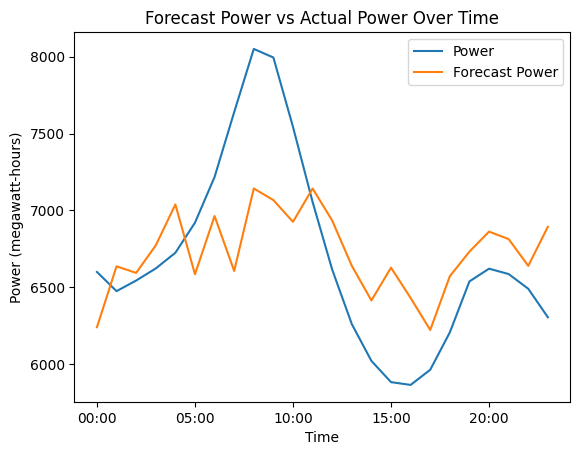

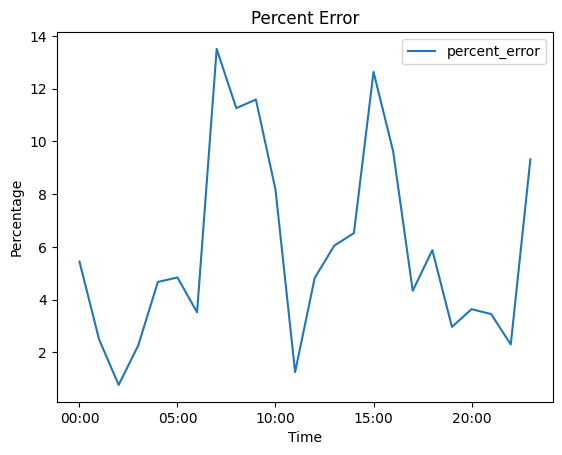

Mean Average Percent Error:  5.885715551200001
------------------------------------------------------
   location  year   date   time  temp  precip  humidity    power  \
0     SCENT  2023  01-14  00:00    30       0        88  6600.64   
1     SCENT  2023  01-14  01:00    34       0        82  6475.98   
2     SCENT  2023  01-14  02:00    33       0        82  6544.83   
3     SCENT  2023  01-14  03:00    36       0        76  6623.43   
4     SCENT  2023  01-14  04:00    37       0        67  6725.10   
5     SCENT  2023  01-14  05:00    30       0        82  6920.59   
6     SCENT  2023  01-14  06:00    28       0        88  7217.57   
7     SCENT  2023  01-14  07:00    26       0        92  7639.02   
8     SCENT  2023  01-14  08:00    29       0        89  8049.55   
9     SCENT  2023  01-14  09:00    41       0        65  7993.80   
10    SCENT  2023  01-14  10:00    50       0        48  7542.87   
11    SCENT  2023  01-14  11:00    57       0        32  7055.07   
12    SCENT  2

In [ ]:
import pandas as pd
import numpy as np
import pymilvus
import time as time
import matplotlib.pyplot as plt
from pathlib import Path
from pymilvus import (
    connections,
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection,
)

# connect to milvus vdb
connections.connect(
  alias="default",
  user='root',
  password='tecafs',
  host='localhost',
  port='19530'
)

# set up embedding model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#while loop allows user to run multiple times
run_again = 'y'
while(run_again == 'y' or run_again == 'yes' or run_again == 'Y' or run_again == 'Yes'):

  # Read in the CSV file
  data_folder = Path("/mnt/c/Users/wcans/milvus_compose/ERCOT_Hourly_Load_2022/")
  csv_file_path = data_folder / "single_day_forecast1.csv"  # Path to raw 2023 data (pre forecasting)
  forecast_df = pd.read_csv(csv_file_path) #create dataframe

  start_day = int(input('Howdy! Data is available for January 2023. Please enter the number of the day to begin forecasting from (1-31): '))
  num_days = int(input('How many days would you like to forecast? '))
  
  if(32-start_day > num_days):
      num_days = 32-start_day
  
  #find indices to start and end at
  end_day = start_day+num_days-1
  start_hour = 24*(start_day-1)
  end_hour = (24*end_day)-1
  
  #filter and set as new dataframe
  filtered_df = forecast_df.iloc[start_hour:end_hour+1]

  #define embedding function
  def get_embedding(prevec):
      text = [prevec]
      embedding = model.encode(text)
      return embedding

  #format the prevector data conglomeration as year/date/time/temp/precip/humidity, then get embeddings
  filtered_df['vector'] = filtered_df.apply(lambda row: get_embedding(f"{row['year']}/{row['date']}/{row['time']}/{row['temp']}/{row['precip']}/{row['humidity']}"), axis=1)
  filtered_df['vector'] = filtered_df['vector'].apply(lambda row: row[0])  #fix formatting of vector

  collection = Collection("small_historical_data")  #get existing milvus collection
  collection.load()  #load collection

  def search(text, top_k = 10):
      # AUTOINDEX does not require any search params, chosen to specify metric
      search_params = {
          "metric_type": "L2"
      }

      #do similarity search
      results = collection.search(
          data = [text],
          anns_field='vector',
          param=search_params,
          limit = top_k,  # Limit to top_k results per search
          ##output_fields=['original_question', 'answer']  # Include the original question and answer in the result
          output_fields=['index', 'year', 'date', 'time', 'temp', 'precip', 'humidity', 'power']
      )
      avg_power = 0
      
      #sum the top_k power values
      for hit in  results[0]:
          avg_power += hit.entity.get('power')

      #calculate average power, adjust to tune for best results
      avg_power= 0.97*(avg_power/top_k)
      return avg_power
      
  filtered_df['forecast_power'] = filtered_df.apply(lambda row: search(row['vector']), axis=1)  

  #Calculate percent error for each row
  filtered_df['percent_error'] = ((abs(filtered_df['forecast_power'] - filtered_df['power'])) / filtered_df['power']) * 100
  
  #Calculate overall percent error
  mean_percent_error = filtered_df['percent_error'].mean()

  # Write the modified DataFrame back to a new CSV file
  output_csv_file_path = data_folder / 'single_day_forecast1_out.csv'  # Replace with the desired output path
  #not enabled at the moment
  #forecast_df.to_csv(output_csv_file_path, index=False)

  #print data
  #create and print plots
  filtered_df.plot(x="time", y=["power", "forecast_power"], kind="line")
  # Display the plot
  plt.title('Forecast Power vs Actual Power Over Time')
  plt.xlabel('Time')
  plt.ylabel('Power (megawatt-hours)')
  plt.legend(['Power', 'Forecast Power'])
  plt.show()

  filtered_df.plot(x='time', y=['percent_error'], kind='line')
  # Display the plot
  plt.title('Percent Error')
  plt.xlabel('Time')
  plt.ylabel('Percentage')
  plt.show()

  print('Mean Average Percent Error: ', mean_percent_error)
  print('------------------------------------------------------')

  filtered_df = filtered_df.drop(columns=['vector'])
  print(filtered_df)
  
  # User Interface
  run_again = input('Would you like to run again? (y/n)')
  

In [ ]:
collection = Collection("small_historical_data")      # Get an existing collection.
collection.load()

#query to filter, then search?

#hybrid search
search_param = {
  "data": [[0.1, 0.2]], ##Search vector
  "anns_field": "book_intro",
  "param": {"metric_type": "L2", "params": {"nprobe": 10}, "offset": 0},
  "limit": 10,
  "expr": "word_count <= 11000",
}
res = collection.search(**search_param)
#search(collection_name, top_k, query_records, partition_tags=None, params=None, timeout=None, **kwargs)

#search
results = collection.search(
    data=[[0.1, 0.2]], 
    anns_field="book_intro", 
    # the sum of `offset` in `param` and `limit` 
    # should be less than 16384.
    param=search_params,
    limit=10,
    expr=None,
    # set the names of the fields you want to 
    # retrieve from the search result.
    output_fields=['title'],
    consistency_level="Strong"
)

# get the IDs of all returned hits
results[0].ids

# get the distances to the query vector from all returned hits
results[0].distances

# get the value of an output field specified in the search request.
hit = results[0][0]
hit.entity.get('title')

In [ ]:
assert len(res) == 1
hits = res[0]
assert len(hits) == 2
print(f"- Total hits: {len(hits)}, hits ids: {hits.ids} ")
print(f"- Top1 hit id: {hits[0].id}, distance: {hits[0].distance}, score: {hits[0].score} ")

In [ ]:
connections.disconnect("default")